In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.04573
cont = np.array([ 1.03658933e-13, -1.93697829e-03, -1.01611922e-13])
sub = 0.6e-16

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)
    return model

def plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)

    return diskout,narrowmodel,broadmodel

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0 

class logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(object):
    def __init__(self, x, y, yerr, lines, linesbroad, fixed, fitted, mins, maxes): 
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.linesbroad = linesbroad
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout, broadout = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return diskout,narrowout,broadout

def loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0) 
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [3]:
fn = '../spec.txt'
wl, flux = np.loadtxt(fn, unpack=True)
flux -= power_law(wl, *cont) - sub
flux *= 0.3e18

olambda = 6563
wavemin = 6100
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [4]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-5   # optical depth normalization (0=no wind)
eta = 0.3 #optical depth power-law index
anglam = 2 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 0 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

# Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

# Broad component
broadwidth = 80
broadHalphaflux = 16

In [5]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 5, 30
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

broadwidthmin, broadwidthmax = 20, 500
broadHalphafluxmin, broadHalphafluxmax = 0.0, 300

diskmins = [
xi1min,xi2min,broadmin,angimin,broadwidthmin,broadHalphafluxmin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,broadwidthmax,broadHalphafluxmax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax]

In [6]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
linesbroad = [6300]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 7
NIIbflux = 3
diskflux = 13
SIIbflux = 0

In [7]:
angi = 22 #disk inclination angle (degrees)
xi1 = 100 #inner disk radius (GM/c^2)
xi2 = 800 #outer disk radius (multiple of xi1)
broad = 1050 #broadening parameter (km/s)

fitted_labels = ['xi1','xi2','broad','angi','broadwidth','broadHalphaflux','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,broadwidth,broadHalphaflux,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,diskflux]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [8]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)
disk,narrowlines,broadlines = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)

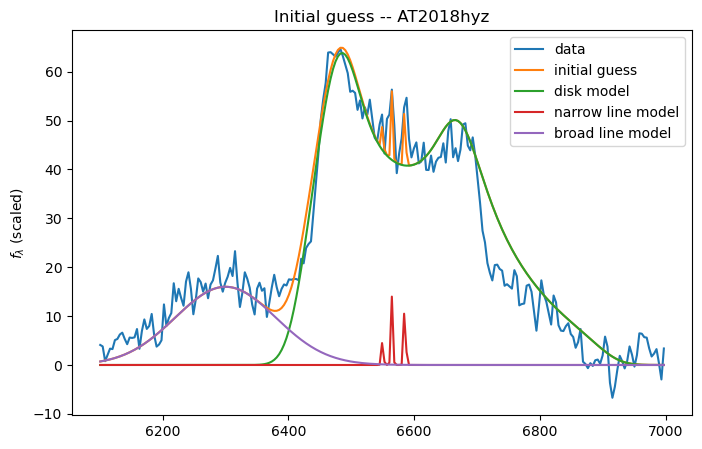

In [9]:
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='broad line model')
plt.ylabel(r'f$_\lambda$ ' + ' (10$^{17}\cdot$erg/s/cm$^2$/Hz)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2018hyz')
plt.legend()
plt.show()

In [10]:
lp = logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

In [11]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [1.22541975e+02 9.41360774e+02 1.00444963e+03 2.21024618e+01
 1.02152631e+02 1.74976141e+01 1.00022234e-01 2.92557920e+00
 1.19156656e+00 2.28100854e+00 1.96872915e-08 2.27621603e-01
 8.33774897e+00 3.38683302e+00 1.20041815e+01]


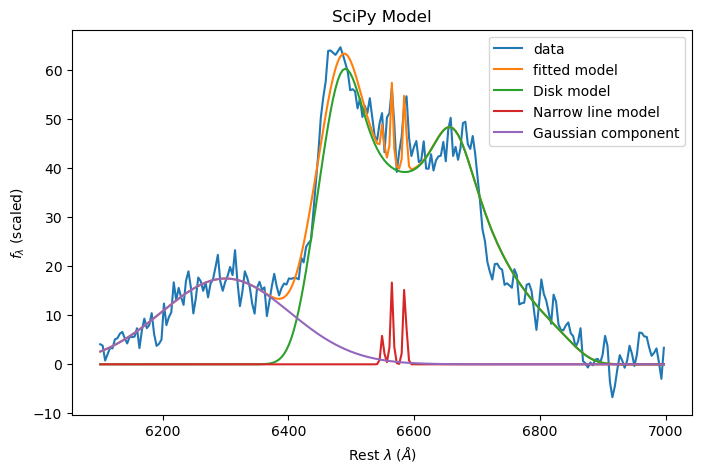

In [12]:
disk,narrowlines,broadlines = lp.plot(soln.x)
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='Gaussian component')
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('SciPy Model'); plt.legend(); plt.show()

In [13]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape; print(pos.shape)
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 10000, progress=True)

(50, 15)


  0%|          | 0/10000 [00:00<?, ?it/s]/home/at4206/.conda/envs/Diskfit/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 15%|█▍        | 1467/10000 [1:48:57<10:51:59,  4.58s/it]/tmp/ipykernel_495487/857628735.py:118: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
100%|██████████| 10000/10000 [12:39:10<00:00,  4.56s/it] 


State([[ 1.19560230e+02  9.05693017e+02  8.69322668e+02  2.30704448e+01
   1.41559251e+02  1.37976167e+01  3.51864611e+00  7.84532775e+00
   2.20088096e+00  1.00009652e+01  4.93967405e-04 -6.86012546e-01
   8.56272843e+00  2.51954671e+00  1.48215196e+01]
 [ 5.36761390e+01  1.50541071e+03  1.47635687e+03 -2.13322972e+01
   9.63346202e+01  2.13891136e+01  2.52390407e-01  4.63697202e+00
   1.54936820e+00  4.17092172e+00  5.14265118e-06  3.38721635e-01
   1.03679642e+01  2.12408074e+00  5.33533662e+00]
 [ 1.26354112e+02  9.28926397e+02  9.68593498e+02  2.38023144e+01
   1.06993561e+02  1.34207279e+01  3.00684929e+00  4.15312674e+00
   1.91465484e+00  1.17005722e+01  8.60368294e-04 -1.33626006e+00
   9.47586060e+00  2.92349252e+00  1.41908765e+01]
 [ 5.59004908e+01  1.72631397e+03  1.17509561e+03 -2.22588936e+01
   9.88495376e+01  1.75479412e+01  4.07818395e-01  4.87659151e+00
   2.54737986e+00  2.87993461e+00  3.37667075e-07  6.65440508e-01
   1.10556636e+01  2.23936144e+00  6.51832704e+00